In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import glob
import os


In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42


main_path = '/content/drive/MyDrive/chest_xray'
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")


train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")


test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")



In [ ]:

import pandas as pd

In [ ]:
df_train = pd.DataFrame({
    "image": train_normal + train_pneumonia,
    "class": ["normal"] * len(train_normal) + ["pneumonia"] * len(train_pneumonia)
})
df_test = pd.DataFrame({
    "image": test_normal + test_pneumonia,
    "class": ["normal"] * len(test_normal) + ["pneumonia"] * len(test_pneumonia)
})

In [ ]:



df_train.shape


(5232, 2)

In [ ]:

df_test.shape

(624, 2)

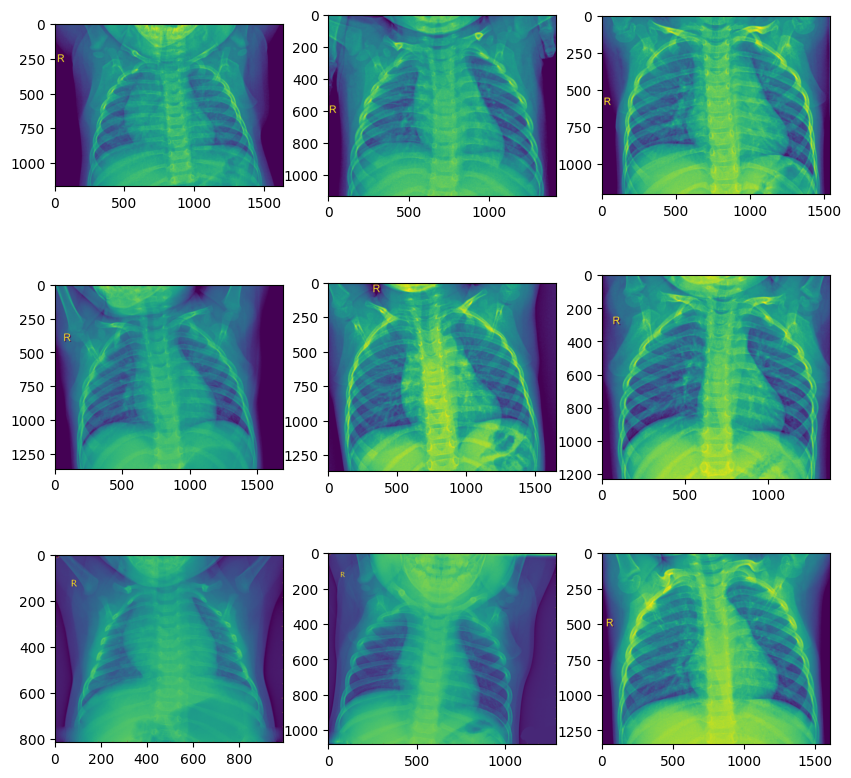

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(df_train.iloc[i, 0])
    plt.imshow(img)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.2,
                                  rotation_range = 0.2,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:

from tensorflow.keras import layers, models, optimizers

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:100]: #Freeze 100 layer đầu
    layer.trainable = False
for layer in base_model.layers[100:]:  # Fine-tune từ layer 100 trở đi
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['Recall'])

In [ ]:
# Train model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=2e-7,
    verbose=1
)
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)
callbacks = [early_stopping,reduce_lr,checkpoint]
history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 133s 802ms/step - Recall: 0.9030 - loss: 0.3580 - val_Recall: 1.0000 - val_loss: 0.8329 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 686ms/step - Recall: 0.9263 - loss: 0.2396 - val_Recall: 0.0211 - val_loss: 0.9898 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 703ms/step - Recall: 0.9443 - loss: 0.2068 - val_Recall: 0.9617 - val_loss: 0.1418 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 690ms/step - Recall: 0.9500 - loss: 0.1770 - val_Recall: 0.8349 - val_loss: 0.2737 - learning_rate: 1.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 688ms/step - Recall: 0.9480 - loss: 0.1975 - val_Recall: 1.0000 - val_loss: 5.3919 - learning_rate: 1.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 683ms/step - Recall: 0.9572 - loss: 0.1621 - val_Recall: 0.2457 - val_loss: 3.0077 - learning_rate: 1.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 696ms/step - Recall: 0.95

In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc}")

624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - Recall: 0.6256 - loss: 0.8133
Test Accuracy: 1.0


624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


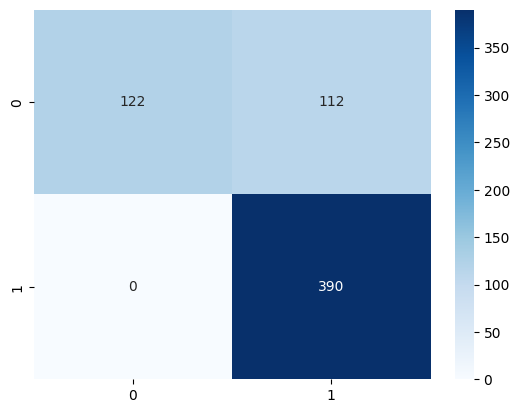

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = (model.predict(ds_test) > 0.5).astype("int")
y_true = ds_test.labels
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.52      0.69       234
           1       0.78      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.89      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624

